In [1]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 100000  # Total de eventos a serem processados
chunk_size = 500   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/lphelipe/Resultados/v2/pp_hh_10x_100TeV.hepmc'
background_file1 = '/home/lphelipe/Resultados/novos/zz_10x_100TeV.hepmc'
background_file2 = '/home/lphelipe/Resultados/v2/jjmumu_10x_100TeV_v2.hepmc'
background_file3 = '/home/lphelipe/Resultados/v2/tt_10x_100TeV_v2.hepmc'
background_file4 = '/home/lphelipe/Resultados/novos/jj_10x_100TeV.hepmc'
background_file5 = '/home/lphelipe/Resultados/v2/pp_zjj_2mu.hepmc'
background_file6 = '/home/lphelipe/Resultados/v2/pp_zjj_2b.hepmc'
background_file7 = '/home/lphelipe/Resultados/v2/pp_hjj_2mu.hepmc'

# Luminosidade do FCC-hh [fb^-1] (20000 fb^-1 = 20 ab^-1)
TARGET_LUMINOSITY = 20000.0  

# Funções para extrair pesos e seções de choque
def extract_cross_section(hepmc_file):
    """Extrai a seção de choque (em pb) da linha 'C' do arquivo .hepmc."""
    with open(hepmc_file, 'r') as f:
        for line in f:
            if line.startswith('C'):
                return float(line.split()[2])  # Pega o segundo valor da linha 'C'
    return 0.0

def extract_weights_from_hepmc(hepmc_file, max_events=max_events):
    """Extrai os pesos brutos de cada evento."""
    weights = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            weights.append(event.weights[-1])  # Assume que o peso nominal é o último
    return np.array(weights)

def normalize_weights(weights, cross_section, luminosity=TARGET_LUMINOSITY, efficiency=1.0):
    """
    Versão corrigida com:
    - Tratamento de pesos negativos
    - Fator de eficiência
    - Verificação de consistência
    """
    # Soma dos valores absolutos para verificação
    sum_abs_weights = np.sum(np.abs(weights))
    
    if sum_abs_weights <= 0 or efficiency <= 0:
        return np.zeros_like(weights)
    
    # Cálculo do fator de normalização (inclui eficiência)
    norm_factor = (cross_section * 1e3 * luminosity) / (np.sum(weights) * efficiency)
    
    # Aplica normalização mantendo o sinal dos pesos
    normalized = weights * norm_factor
    
    # Verificação de consistência (debug)
    expected_sum = cross_section * 1e3 * luminosity
    actual_sum = np.sum(normalized)
    
    print(f"Verificação: σ={cross_section}pb → Σpesos_normalizados={actual_sum:.1f} (esperado={expected_sum:.1f})")
    
    return normalized

# Extrair seções de choque e pesos brutos
cross_section_signal = extract_cross_section(sinal_file)
cross_section_bkg1 = extract_cross_section(background_file1)
cross_section_bkg2 = extract_cross_section(background_file2)
cross_section_bkg3 = extract_cross_section(background_file3)
cross_section_bkg4 = extract_cross_section(background_file4)
cross_section_bkg5 = extract_cross_section(background_file5)
cross_section_bkg6 = extract_cross_section(background_file6)
cross_section_bkg7 = extract_cross_section(background_file7)

print("\nSeções de choque extraídas (deveriam estar em pb):")
print(f"Sinal: {cross_section_signal} pb")
print(f"Backgrounds: {cross_section_bkg1}, {cross_section_bkg2}, {cross_section_bkg3}, {cross_section_bkg4}, {cross_section_bkg5}, {cross_section_bkg6}, {cross_section_bkg7} pb")

signal_weights_raw = extract_weights_from_hepmc(sinal_file)
bkg1_weights_raw = extract_weights_from_hepmc(background_file1)
bkg2_weights_raw = extract_weights_from_hepmc(background_file2)
bkg3_weights_raw = extract_weights_from_hepmc(background_file3)
bkg4_weights_raw = extract_weights_from_hepmc(background_file4)
bkg5_weights_raw = extract_weights_from_hepmc(background_file5)
bkg6_weights_raw = extract_weights_from_hepmc(background_file6)
bkg7_weights_raw = extract_weights_from_hepmc(background_file7)

# Normalizar pesos para a luminosidade do FCC-hh
signal_weights = normalize_weights(signal_weights_raw, cross_section_signal)
bkg1_weights = normalize_weights(bkg1_weights_raw, cross_section_bkg1)
bkg2_weights = normalize_weights(bkg2_weights_raw, cross_section_bkg2)
bkg3_weights = normalize_weights(bkg3_weights_raw, cross_section_bkg3)
bkg4_weights = normalize_weights(bkg4_weights_raw, cross_section_bkg4)
bkg5_weights = normalize_weights(bkg5_weights_raw, cross_section_bkg5)
bkg6_weights = normalize_weights(bkg6_weights_raw, cross_section_bkg6)
bkg7_weights = normalize_weights(bkg7_weights_raw, cross_section_bkg7)

# Verificação global dos pesos
print("\nVerificação final dos pesos:")
print(f"Sinal: Σ={np.sum(signal_weights):.2f} (esperado={cross_section_signal*1e3*TARGET_LUMINOSITY:.2f})")
print(f"Background 1: Σ={np.sum(bkg1_weights):.2f} (esperado={cross_section_bkg1*1e3*TARGET_LUMINOSITY:.2f})")

# Função para ler eventos HEPMC em chunks (com tratamento de eventos corrompidos)
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            if event is None:  # Ignora eventos corrompidos
                print(f"⚠️ Evento inválido na linha {i + 1} - pulando...")
                continue
            events.append(event)
            if (i + 1) % chunk_size == 0:
                yield events
                events = []
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()
        if events:
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        mean_displacement = np.mean(secondary_vertex_displacement)
        return mean_displacement > 1.0, mean_displacement  # Retorna se é b-tagged e a distância média
    return False, 0.0  # Retorna False e distância 0.0 se não houver vértices secundários

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para remover múons das partículas
def remove_muons(particles):
    return [p for p in particles if abs(p.pid) != 13]  # Múons têm PID ±13

# Função para remover múons das partículas
def find_opposite_charge_muons(particles):
    # Filtra múons que passam os cortes básicos
    muons = [p for p in particles if abs(p.pid) == 13 and p.momentum.pt() > 20.0 and abs(p.momentum.eta()) < 2.5]
    
    # Ordena todos os múons por pT (do maior para o menor)
    muons_sorted = sorted(muons, key=lambda m: m.momentum.pt(), reverse=True)
    
    pairs = []
    used_indices = set()
    
    # Forma pares com cargas opostas
    for i in range(len(muons_sorted)):
        if i in used_indices:
            continue
        for j in range(i + 1, len(muons_sorted)):
            if j in used_indices:
                continue
            if muons_sorted[i].pid == -muons_sorted[j].pid:
                pairs.append((muons_sorted[i], muons_sorted[j]))
                used_indices.add(i)
                used_indices.add(j)
                break  # Pega apenas o próximo múon com carga oposta
    
    return pairs

# Função para calcular deltaR entre dois jatos
def delta_r(jet1, jet2):
    dphi = jet1.phi() - jet2.phi()
    deta = jet1.eta() - jet2.eta()
    return np.sqrt(dphi**2 + deta**2)

# Função para processar eventos e extrair informações
def extract_event_info(events, weights=None):
    """Adicione o parâmetro weights e inclua-o no DataFrame."""
    data = []
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis) e pT > 2 GeV
        particles = [p for p in event.particles if p.status == 1 and p.momentum.pt() > 2.0]
        
        # Identificar pares de múons com cargas opostas (já ordenados por pT)
        muon_pairs = find_opposite_charge_muons(particles)

        # Pular evento se não houver pares válidos
        if not muon_pairs:
            continue

        # Pegar APENAS o PRIMEIRO par (já ordenado por pT)
        muon1 = fj.PseudoJet(muon_pairs[0][0].momentum.x, muon_pairs[0][0].momentum.y, 
                             muon_pairs[0][0].momentum.z, muon_pairs[0][0].momentum.e)
        muon2 = fj.PseudoJet(muon_pairs[0][1].momentum.x, muon_pairs[0][1].momentum.y, 
                             muon_pairs[0][1].momentum.z, muon_pairs[0][1].momentum.e)
        
        inv_mass = invariant_mass(muon1, muon2)
            
        # Corte na massa invariante dos múons (100-150 GeV)
        if not (100 < inv_mass < 150):
            continue

        # Preencher informações dos múons (sempre os dois de maior pT)
        muon_info = {
            'muon_mass': inv_mass,
            'muon1_pt': muon1.pt(),  # Maior pT
            'muon2_pt': muon2.pt(),  # Segundo maior pT
            'muon1_energy': muon1.e(),
            'muon2_energy': muon2.e(),
            'di_muon_energy': muon1.e() + muon2.e(),
            'di_muon_pt': muon1.pt() + muon2.pt()
        }

        # Remover múons das partículas
        particles_no_muons = remove_muons(particles)
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) 
                        for p in particles_no_muons]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV e |η| < 4.5
        jets = [j for j in clusterer.inclusive_jets(30.0) if abs(j.eta()) < 4.5]
        
        # Ordenar jatos por pT (decrescente)
        jets_sorted = sorted(jets, key=lambda j: j.pt(), reverse=True)
        
        # Informações dos jatos (apenas os 2 jatos líderes em pT)
        jet_info = {}
        if len(jets_sorted) >= 2:
            # Pegar os dois jatos de maior pT
            jet1, jet2 = jets_sorted[0], jets_sorted[1]
            
            # Verificar b-tagging apenas para esses dois jatos
            is_b_tagged1, b_tag_distance1 = is_b_tagged(jet1, particles_no_muons)
            is_b_tagged2, b_tag_distance2 = is_b_tagged(jet2, particles_no_muons)
            
            # Calcular massa invariante dos dijets
            dijet_mass = invariant_mass(jet1, jet2)
            
            # Aplicar corte na massa dos dijets (90-160 GeV)
            if not (90 <= dijet_mass <= 160):
                continue  # Pula o evento se a massa estiver fora da janela
            
            # Preencher informações apenas se passar o corte de massa
            jet_info = {
                'dijet_mass': dijet_mass,
                'jet1_pt': jet1.pt(),       # Jato com maior pT
                'jet2_pt': jet2.pt(),       # Jato com segundo maior pT
                'jet1_energy': jet1.e(),
                'jet2_energy': jet2.e(),
                'di_jet_energy': jet1.e() + jet2.e(),
                'di_jet_pt': jet1.pt() + jet2.pt(),
                'delta_r': delta_r(jet1, jet2),
                'num_jets': len(jets),
                'jet1_is_b_tagged': is_b_tagged1,
                'jet2_is_b_tagged': is_b_tagged2,
                'b_tag_distance1': b_tag_distance1 if is_b_tagged1 else 0.0,
                'b_tag_distance2': b_tag_distance2 if is_b_tagged2 else 0.0
            }
        else:
            continue  # Pula o evento se não tiver pelo menos 2 jatos
            
        # Combinar informações
        event_info = {
            **muon_info, 
            **jet_info,
            'weight': weights[i] if weights is not None else 1.0
        }
        data.append(event_info)
        
    return pd.DataFrame(data)

# Processar eventos de sinal
signal_df = pd.concat([
    extract_event_info(chunk, signal_weights[i * chunk_size : (i + 1) * chunk_size])
    for i, chunk in enumerate(read_hepmc_file_in_chunks(sinal_file))
])
signal_df['label'] = 1

# Processar eventos de background
background1_df = pd.concat([
    extract_event_info(chunk, bkg1_weights[i * chunk_size : (i + 1) * chunk_size])
    for i, chunk in enumerate(read_hepmc_file_in_chunks(background_file1))
])
background1_df['label'] = 0

background2_df = pd.concat([
    extract_event_info(chunk, bkg2_weights[i * chunk_size : (i + 1) * chunk_size])
    for i, chunk in enumerate(read_hepmc_file_in_chunks(background_file2))
])
background2_df['label'] = 0

background3_df = pd.concat([
    extract_event_info(chunk, bkg3_weights[i * chunk_size : (i + 1) * chunk_size])
    for i, chunk in enumerate(read_hepmc_file_in_chunks(background_file3))
])
background3_df['label'] = 0

background4_df = pd.concat([
    extract_event_info(chunk, bkg4_weights[i * chunk_size : (i + 1) * chunk_size])
    for i, chunk in enumerate(read_hepmc_file_in_chunks(background_file4))
])
background4_df['label'] = 0

background5_df = pd.concat([
    extract_event_info(chunk, bkg5_weights[i * chunk_size : (i + 1) * chunk_size])
    for i, chunk in enumerate(read_hepmc_file_in_chunks(background_file5))
])
background5_df['label'] = 0

background6_df = pd.concat([
    extract_event_info(chunk, bkg6_weights[i * chunk_size : (i + 1) * chunk_size])
    for i, chunk in enumerate(read_hepmc_file_in_chunks(background_file6))
])
background6_df['label'] = 0

background7_df = pd.concat([
    extract_event_info(chunk, bkg7_weights[i * chunk_size : (i + 1) * chunk_size])
    for i, chunk in enumerate(read_hepmc_file_in_chunks(background_file7))
])
background7_df['label'] = 0

# Diretório de saída
output_dir = "resultados_csv"
os.makedirs(output_dir, exist_ok=True)

# Nomes dos arquivos
signal_csv_path = os.path.join(output_dir, "signal_cuts_v5.csv")
background_csv_path = os.path.join(output_dir, "background_cuts_v5.csv")
combined_csv_path = os.path.join(output_dir, "all_events_cuts_v5.csv")

# Salvar sinal (label=1)
signal_df.to_csv(signal_csv_path, index=False)
print(f"\n✅ Sinal salvo em: {signal_csv_path}")
print(f"   Eventos de sinal que passaram nos cortes: {len(signal_df)}")

# Salvar backgrounds combinados (labels=0)
background_df = pd.concat([background1_df, background2_df, background3_df, background4_df, background5_df, background6_df, background7_df])
background_df.to_csv(background_csv_path, index=False)
print(f"\n✅ Background salvo em: {background_csv_path}")
print(f"   Eventos de background que passaram nos cortes: {len(background_df)}")

#Salvar arquivo combinado (sinal + background)
combined_df = pd.concat([signal_df, background_df])
combined_df.to_csv(combined_csv_path, index=False)
print(f"\n✅ Arquivo combinado salvo em: {combined_csv_path}")
print(f"   Total de eventos salvos: {len(combined_df)}")


2025-07-31 18:41:43.056226: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-31 18:41:43.061041: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-31 18:41:43.071168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753998103.088089      67 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753998103.093675      67 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753998103.111533      67 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin


Seções de choque extraídas (deveriam estar em pb):
Sinal: 0.00019551555000000003 pb
Backgrounds: 0.41527337000000003, 1391.0738, 23634.11, 7618481000.0, 2991.8412, 13115.428000000002, 0.0058834667 pb


ERROR::ReaderAsciiHepMC2: HEPMC3_ERROR parsing particle information
ERROR::ReaderAsciiHepMC2: event parsing failed. Returning empty event


DEBUG(1)::Parsing failed at line:
P 4218 221 -1.3387562975612219e+


ERROR::ReaderAsciiHepMC2: HEPMC3_ERROR parsing particle information
ERROR::ReaderAsciiHepMC2: event parsing failed. Returning empty event


DEBUG(1)::Parsing failed at line:
P 2414 211 -1.9511519670023364e-01 -3.1322666161810855e-02 2.9672035445183886e+00 2.9770501690266058e+00 1.395700000000000


ERROR::ReaderAsciiHepMC2: HEPMC3_ERROR parsing particle information
ERROR::ReaderAsciiHepMC2: event parsing failed. Returning empty event


DEBUG(1)::Parsing failed at line:
P 4193 -211 4.315245
Verificação: σ=0.00019551555000000003pb → Σpesos_normalizados=3910.3 (esperado=3910.3)
Verificação: σ=0.41527337000000003pb → Σpesos_normalizados=8305467.4 (esperado=8305467.4)
Verificação: σ=1391.0738pb → Σpesos_normalizados=27821476000.0 (esperado=27821476000.0)
Verificação: σ=23634.11pb → Σpesos_normalizados=472682200000.0 (esperado=472682200000.0)
Verificação: σ=7618481000.0pb → Σpesos_normalizados=152369620000000000.0 (esperado=152369620000000000.0)
Verificação: σ=2991.8412pb → Σpesos_normalizados=59836824000.0 (esperado=59836824000.0)
Verificação: σ=13115.428000000002pb → Σpesos_normalizados=262308560000.0 (esperado=262308560000.0)
Verificação: σ=0.0058834667pb → Σpesos_normalizados=117669.3 (esperado=117669.3)

Verificação final dos pesos:
Sinal: Σ=3910.31 (esperado=3910.31)
Background 1: Σ=8305467.40 (esperado=8305467.40)
#--------------------------------------------------------------------------
#                         F

ERROR::ReaderAsciiHepMC2: HEPMC3_ERROR parsing particle information
ERROR::ReaderAsciiHepMC2: event parsing failed. Returning empty event


DEBUG(1)::Parsing failed at line:
P 4218 221 -1.3387562975612219e+
Eventos lidos: 500
Uso de memória: 2429.41 MB
Eventos lidos: 1000
Uso de memória: 2429.41 MB
Eventos lidos: 1500
Uso de memória: 2429.41 MB
Eventos lidos: 2000
Uso de memória: 2429.41 MB
Eventos lidos: 2500
Uso de memória: 2429.41 MB
Eventos lidos: 3000
Uso de memória: 2429.41 MB
Eventos lidos: 3500
Uso de memória: 2429.41 MB
Eventos lidos: 4000
Uso de memória: 2429.41 MB
Eventos lidos: 4500
Uso de memória: 2429.41 MB
Eventos lidos: 5000
Uso de memória: 2429.41 MB
Eventos lidos: 5500
Uso de memória: 2429.41 MB
Eventos lidos: 6000
Uso de memória: 2429.41 MB
Eventos lidos: 6500
Uso de memória: 2429.41 MB
Eventos lidos: 7000
Uso de memória: 2429.41 MB
Eventos lidos: 7500
Uso de memória: 2429.41 MB
Eventos lidos: 8000
Uso de memória: 2429.41 MB
Eventos lidos: 8500
Uso de memória: 2429.41 MB
Eventos lidos: 9000
Uso de memória: 2429.41 MB
Eventos lidos: 9500
Uso de memória: 2429.41 MB
Eventos lidos: 10000
Uso de memória: 2429

ERROR::ReaderAsciiHepMC2: HEPMC3_ERROR parsing particle information
ERROR::ReaderAsciiHepMC2: event parsing failed. Returning empty event


Eventos lidos: 500
Uso de memória: 2429.75 MB
Eventos lidos: 1000
Uso de memória: 2429.75 MB
Eventos lidos: 1500
Uso de memória: 2429.75 MB
Eventos lidos: 2000
Uso de memória: 2429.75 MB
Eventos lidos: 2500
Uso de memória: 2429.75 MB
Eventos lidos: 3000
Uso de memória: 2429.75 MB
Eventos lidos: 3500
Uso de memória: 2429.75 MB
Eventos lidos: 4000
Uso de memória: 2429.75 MB
Eventos lidos: 4500
Uso de memória: 2429.75 MB
Eventos lidos: 5000
Uso de memória: 2429.75 MB
Eventos lidos: 5500
Uso de memória: 2429.75 MB
Eventos lidos: 6000
Uso de memória: 2429.75 MB
Eventos lidos: 6500
Uso de memória: 2429.75 MB
Eventos lidos: 7000
Uso de memória: 2429.75 MB
Eventos lidos: 7500
Uso de memória: 2429.75 MB
Eventos lidos: 8000
Uso de memória: 2429.75 MB
Eventos lidos: 8500
Uso de memória: 2429.75 MB
Eventos lidos: 9000
Uso de memória: 2429.75 MB
Eventos lidos: 9500
Uso de memória: 2429.75 MB
Eventos lidos: 10000
Uso de memória: 2429.75 MB
Eventos lidos: 10500
Uso de memória: 2447.50 MB
Eventos lido

ERROR::ReaderAsciiHepMC2: HEPMC3_ERROR parsing particle information
ERROR::ReaderAsciiHepMC2: event parsing failed. Returning empty event


DEBUG(1)::Parsing failed at line:
P 4193 -211 4.315245
Eventos lidos: 500
Uso de memória: 2452.11 MB
Eventos lidos: 1000
Uso de memória: 2452.11 MB
Eventos lidos: 1500
Uso de memória: 2452.11 MB
Eventos lidos: 2000
Uso de memória: 2452.11 MB
Eventos lidos: 2500
Uso de memória: 2452.11 MB
Eventos lidos: 3000
Uso de memória: 2452.11 MB
Eventos lidos: 3500
Uso de memória: 2452.11 MB
Eventos lidos: 4000
Uso de memória: 2452.11 MB
Eventos lidos: 4500
Uso de memória: 2452.11 MB
Eventos lidos: 5000
Uso de memória: 2452.11 MB
Eventos lidos: 5500
Uso de memória: 2452.11 MB
Eventos lidos: 6000
Uso de memória: 2452.11 MB
Eventos lidos: 6500
Uso de memória: 2452.11 MB
Eventos lidos: 7000
Uso de memória: 2452.11 MB
Eventos lidos: 7500
Uso de memória: 2452.11 MB
Eventos lidos: 8000
Uso de memória: 2452.11 MB
Eventos lidos: 8500
Uso de memória: 2452.11 MB
Eventos lidos: 9000
Uso de memória: 2452.11 MB
Eventos lidos: 9500
Uso de memória: 2452.11 MB
Eventos lidos: 10000
Uso de memória: 2452.11 MB
Event

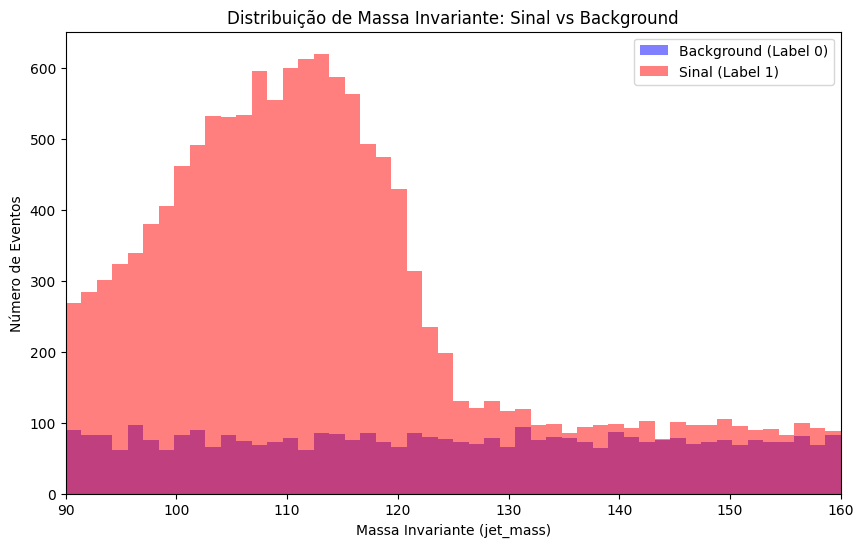

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados do arquivo CSV
data = pd.read_csv('/home/lphelipe/Cuts_code/resultados_csv/all_events_cuts_v5.csv')  # Substitua 'seu_arquivo.csv' pelo nome do seu arquivo

# Separar sinal (label 1) e background (label 0)
sinal = data[data['label'] == 1]['dijet_mass']
background = data[data['label'] == 0]['dijet_mass']

# Criar o plot
plt.figure(figsize=(10, 6))

# Plotar o background primeiro (label 0)
plt.hist(background, bins=50, alpha=0.5, label='Background (Label 0)', color='blue')

# Plotar o sinal por cima (label 1)
plt.hist(sinal, bins=50, alpha=0.5, label='Sinal (Label 1)', color='red')

# Adicionar legendas e título
plt.xlabel('Massa Invariante (jet_mass)')
plt.ylabel('Número de Eventos')
plt.xlim(90 ,160)
plt.title('Distribuição de Massa Invariante: Sinal vs Background')
plt.legend()

# Mostrar o plot
plt.show()

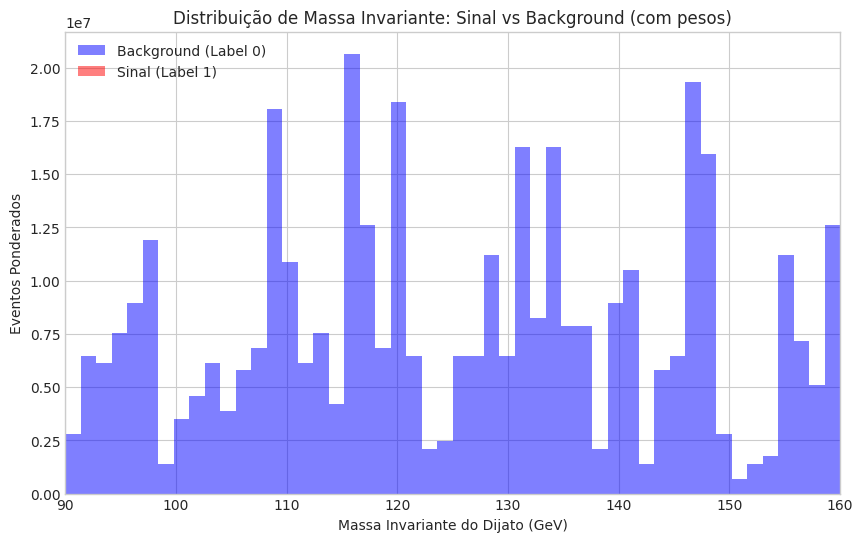

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados do arquivo CSV
data = pd.read_csv('/home/lphelipe/Cuts_code/resultados_csv/all_events_cuts_v5.csv')

# Separar sinal (label 1) e background (label 0) com seus pesos
sinal = data[data['label'] == 1]
background = data[data['label'] == 0]

# Criar o plot
plt.figure(figsize=(10, 6))

# Plotar o background (label 0) com pesos
plt.hist(
    background['dijet_mass'],
    bins=50,
    weights=background['weight'],  # Incluindo os pesos
    alpha=0.5,
    label='Background (Label 0)',
    color='blue'
)

# Plotar o sinal (label 1) com pesos
plt.hist(
    sinal['dijet_mass'],
    bins=50,
    weights=sinal['weight'],  # Incluindo os pesos
    alpha=0.5,
    label='Sinal (Label 1)',
    color='red'
)

# Configurações do gráfico
plt.xlabel('Massa Invariante do Dijato (GeV)')
plt.ylabel('Eventos Ponderados')  # Mudei o rótulo para refletir os pesos
plt.xlim(90, 160)
plt.title('Distribuição de Massa Invariante: Sinal vs Background (com pesos)')
plt.legend()

# Mostrar o plot
plt.show()

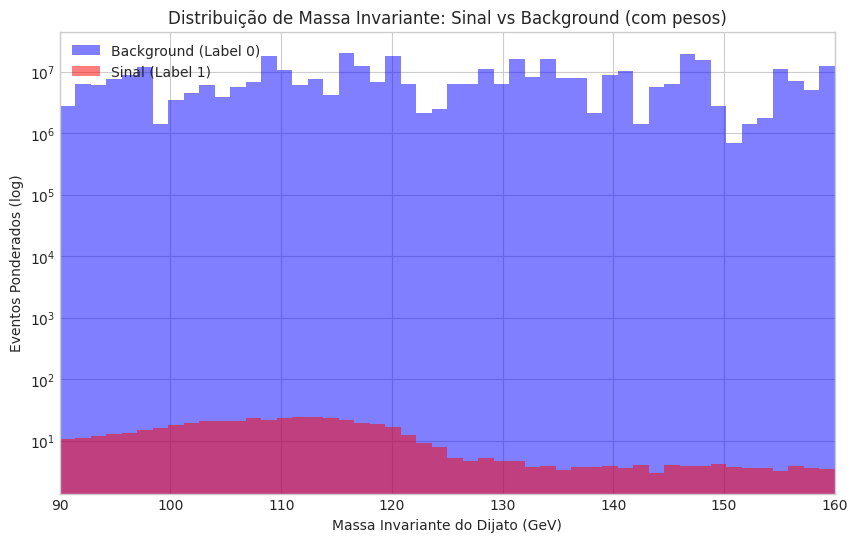

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados do arquivo CSV
data = pd.read_csv('/home/lphelipe/Cuts_code/resultados_csv/all_events_cuts_v5.csv')

# Separar sinal (label 1) e background (label 0) com seus pesos
sinal = data[data['label'] == 1]
background = data[data['label'] == 0]

# Criar o plot
plt.figure(figsize=(10, 6))

# Plotar o background (label 0) com pesos
plt.hist(
    background['dijet_mass'],
    bins=50,
    weights=background['weight'],  # Incluindo os pesos
    alpha=0.5,
    label='Background (Label 0)',
    color='blue'
)

# Plotar o sinal (label 1) com pesos
plt.hist(
    sinal['dijet_mass'],
    bins=50,
    weights=sinal['weight'],  # Incluindo os pesos
    alpha=0.5,
    label='Sinal (Label 1)',
    color='red'
)

# Configurações do gráfico
plt.xlabel('Massa Invariante do Dijato (GeV)')
plt.ylabel('Eventos Ponderados (log)')  # Adicionei "(log)" para indicar escala log
plt.xlim(90, 160)
plt.yscale('log')  # Escala logarítmica no eixo y
plt.title('Distribuição de Massa Invariante: Sinal vs Background (com pesos)')
plt.legend()

# Mostrar o plot
plt.show()

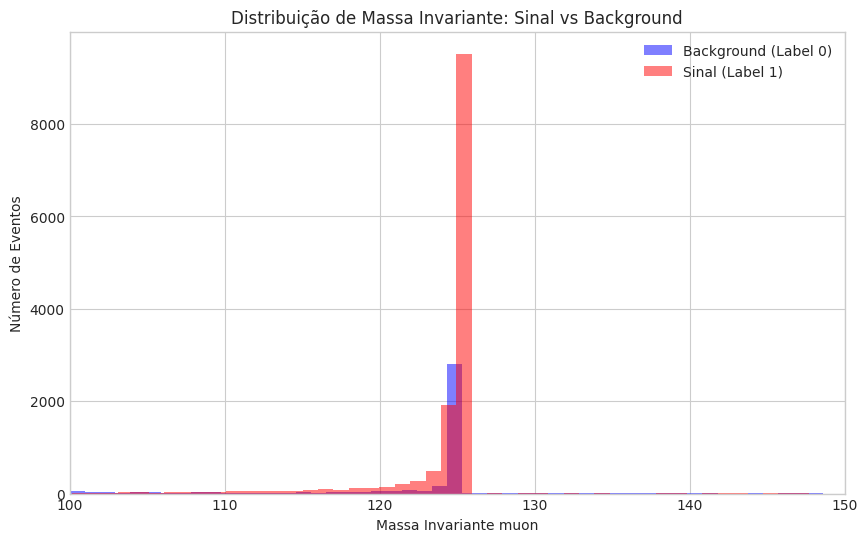

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados do arquivo CSV
data = pd.read_csv('/home/lphelipe/Cuts_code/resultados_csv/all_events_cuts_v5.csv')  # Substitua 'seu_arquivo.csv' pelo nome do seu arquivo

# Separar sinal (label 1) e background (label 0)
sinal = data[data['label'] == 1]['muon_mass']
background = data[data['label'] == 0]['muon_mass']

# Criar o plot
plt.figure(figsize=(10, 6))

# Plotar o background primeiro (label 0)
plt.hist(background, bins=50, alpha=0.5, label='Background (Label 0)', color='blue')

# Plotar o sinal por cima (label 1)
plt.hist(sinal, bins=50, alpha=0.5, label='Sinal (Label 1)', color='red')

# Adicionar legendas e título
plt.xlabel('Massa Invariante muon')
plt.ylabel('Número de Eventos')
plt.xlim(100 ,150)
plt.title('Distribuição de Massa Invariante: Sinal vs Background')
plt.legend()

# Mostrar o plot
plt.show()

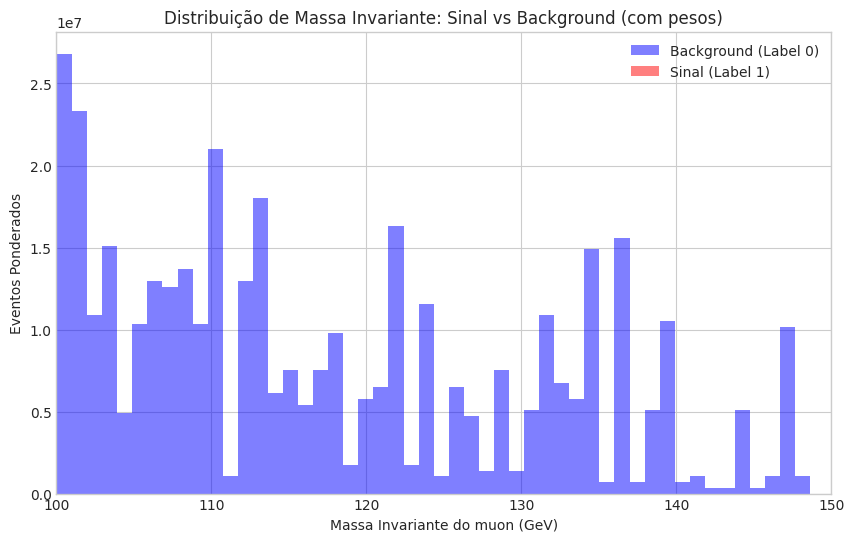

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados do arquivo CSV
data = pd.read_csv('/home/lphelipe/Cuts_code/resultados_csv/all_events_cuts_v5.csv')

# Separar sinal (label 1) e background (label 0) com seus pesos
sinal = data[data['label'] == 1]
background = data[data['label'] == 0]

# Criar o plot
plt.figure(figsize=(10, 6))

# Plotar o background (label 0) com pesos
plt.hist(
    background['muon_mass'],
    bins=50,
    weights=background['weight'],  # Incluindo os pesos
    alpha=0.5,
    label='Background (Label 0)',
    color='blue'
)

# Plotar o sinal (label 1) com pesos
plt.hist(
    sinal['muon_mass'],
    bins=50,
    weights=sinal['weight'],  # Incluindo os pesos
    alpha=0.5,
    label='Sinal (Label 1)',
    color='red'
)

# Configurações do gráfico
plt.xlabel('Massa Invariante do muon (GeV)')
plt.ylabel('Eventos Ponderados')  # Mudei o rótulo para refletir os pesos
plt.xlim(100, 150)
plt.title('Distribuição de Massa Invariante: Sinal vs Background (com pesos)')
plt.legend()

# Mostrar o plot
plt.show()

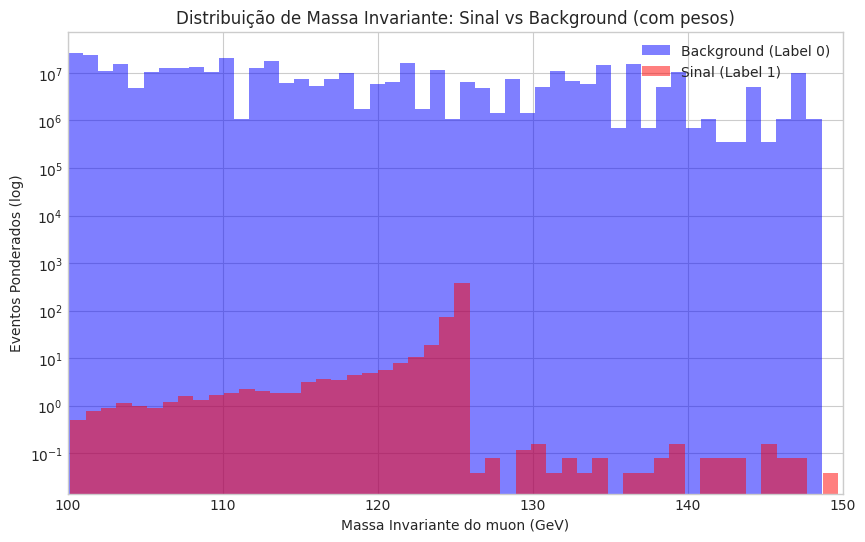

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados do arquivo CSV
data = pd.read_csv('/home/lphelipe/Cuts_code/resultados_csv/all_events_cuts_v5.csv')

# Separar sinal (label 1) e background (label 0) com seus pesos
sinal = data[data['label'] == 1]
background = data[data['label'] == 0]

# Criar o plot
plt.figure(figsize=(10, 6))

# Plotar o background (label 0) com pesos
plt.hist(
    background['muon_mass'],
    bins=50,
    weights=background['weight'],  # Incluindo os pesos
    alpha=0.5,
    label='Background (Label 0)',
    color='blue'
)

# Plotar o sinal (label 1) com pesos
plt.hist(
    sinal['muon_mass'],
    bins=50,
    weights=sinal['weight'],  # Incluindo os pesos
    alpha=0.5,
    label='Sinal (Label 1)',
    color='red'
)

# Configurações do gráfico
plt.xlabel('Massa Invariante do muon (GeV)')
plt.ylabel('Eventos Ponderados (log)')  # Adicionei "(log)" para indicar escala log
plt.xlim(100, 150)
plt.yscale('log')  # Escala logarítmica no eixo y
plt.title('Distribuição de Massa Invariante: Sinal vs Background (com pesos)')
plt.legend()

# Mostrar o plot
plt.show()

In [61]:
import pandas as pd

# Caminho do arquivo CSV
caminho_arquivo = '/home/lphelipe/Cuts_code/resultados_csv/all_events_cuts_v5.csv'

# Leitura do arquivo
df = pd.read_csv(caminho_arquivo)

# Visualização das primeiras linhas
df.head(15)

,muon_mass,muon1_pt,muon2_pt,muon1_energy,muon2_energy,di_muon_energy,di_muon_pt,dijet_mass,jet1_pt,jet2_pt,...,di_jet_energy,di_jet_pt,delta_r,num_jets,jet1_is_b_tagged,jet2_is_b_tagged,b_tag_distance1,b_tag_distance2,weight,label
0,125.000000,355.822375,77.034847,378.012348,78.678465,456.690813,432.857222,99.488333,452.187718,36.978090,...,501.777267,489.165807,0.616395,3.0,True,True,824.545479,824.545479,0.039103,1
1,125.000000,151.385390,35.062341,190.930862,35.596173,226.527035,186.447731,116.444253,81.341675,71.563736,...,220.096875,152.905411,1.565242,3.0,True,True,27.819664,27.819664,0.039103,1
2,125.000000,120.893303,63.002514,522.052880,141.222823,663.275703,183.895817,121.967381,88.257213,42.810200,...,330.247780,131.067414,1.996086,2.0,True,True,7.700815,7.700815,0.039103,1
3,124.999881,79.800961,76.568096,95.431489,111.545181,206.976670,156.369058,130.684266,104.654717,54.213372,...,333.205680,158.868089,1.974636,2.0,True,True,27.407226,27.407226,0.039103,1
4,125.000000,147.676697,26.546691,147.711740,35.503714,183.215454,174.223387,114.437635,103.701625,78.146902,...,267.350585,181.848527,1.235293,3.0,True,True,6.662962,6.662962,0.039103,1
5,125.000000,158.829864,121.704386,195.191903,181.808791,377.000694,280.534249,107.084469,118.795162,73.103208,...,211.354958,191.898370,1.161397,3.0,True,True,13.525662,13.525662,0.039103,1
6,124.995247,148.853308,23.408051,162.326586,41.835409,204.161994,172.261359,113.109001,107.871301,52.161431,...,404.014673,160.032732,1.692877,2.0,True,True,13.675044,13.675044,0.039103,1
7,125.000000,96.332437,87.684538,103.059481,92.771786,195.831267,184.016975,104.710854,73.768997,66.830753,...,173.394672,140.599750,1.404256,2.0,True,True,78.595466,78.595466,0.039103,1
8,124.896658,239.033228,138.369103,670.226451,740.734986,1410.961437,377.402331,123.478500,339.347929,186.968230,...,1433.223680,526.316160,0.477532,6.0,True,True,6.446508,6.446508,0.039103,1
9,123.133668,242.154417,157.043583,909.692479,637.919255,1547.611734,399.198000,114.193901,279.506079,77.610631,...,4009.644836,357.116710,0.743307,2.0,True,True,21.073755,21.073755,0.039103,1


In [62]:
df.tail(15)

,muon_mass,muon1_pt,muon2_pt,muon1_energy,muon2_energy,di_muon_energy,di_muon_pt,dijet_mass,jet1_pt,jet2_pt,...,di_jet_energy,di_jet_pt,delta_r,num_jets,jet1_is_b_tagged,jet2_is_b_tagged,b_tag_distance1,b_tag_distance2,weight,label
17420,125.000000,80.663936,55.582738,291.660334,126.575275,418.235609,136.246674,157.228493,100.551208,58.734735,...,243.351673,159.285944,2.121962,2.0,True,True,8.642663,8.642663,1.176693,0
17421,113.564581,136.685981,26.000943,138.571747,26.390804,164.962551,162.686924,151.768556,104.523310,89.624625,...,794.304888,194.147936,4.594578,5.0,True,True,35.940119,35.940119,1.176693,0
17422,125.000000,41.638785,38.317243,194.440771,38.327229,232.768000,79.956027,121.058789,56.348247,41.876920,...,530.954901,98.225167,3.014572,2.0,True,True,59.251824,59.251824,1.176693,0
17423,125.000000,99.968541,61.720654,168.909176,100.641854,269.551030,161.689195,127.014299,105.959932,30.334120,...,421.896626,136.294052,2.684406,2.0,True,True,34.535695,34.535695,1.176693,0
17424,125.000000,104.789232,72.020056,113.910791,75.804050,189.714840,176.809287,140.783524,74.675539,54.583168,...,226.320590,129.258706,1.986573,2.0,True,True,22.173141,22.173141,1.176693,0
17425,124.988551,121.133062,34.572747,165.969088,34.808336,200.777425,155.705808,141.753877,56.212108,40.427068,...,1075.744518,96.639176,2.504088,2.0,True,True,96.272150,96.272150,1.176693,0
17426,125.000000,88.444914,45.612482,111.597642,98.388303,209.985945,134.057397,98.817210,45.740026,30.630139,...,116.031449,76.370165,2.550504,2.0,True,True,14.462713,14.462713,1.176693,0
17427,115.039791,128.336770,62.567719,129.357542,68.601116,197.958657,190.904490,135.061584,116.240170,48.099524,...,209.044038,164.339694,2.160832,4.0,True,True,8.207364,8.207364,1.176693,0
17428,124.999392,109.932567,34.790531,172.473940,35.629534,208.103474,144.723098,133.722981,64.790978,61.921598,...,228.175664,126.712575,3.796352,4.0,True,True,14.108614,14.108614,1.176693,0
17429,124.992428,79.991423,44.931028,87.702063,47.854287,135.556350,124.922452,143.817910,65.368530,63.009759,...,155.503130,128.378289,2.847369,2.0,True,True,96.535432,96.535432,1.176693,0


In [63]:
df.shape  # (n_linhas, n_colunas)

(17435, 22)

In [64]:
# Lendo apenas o cabeçalho do arquivo CSV
try:
    df = pd.read_csv(caminho_arquivo, nrows=0)  # nrows=0 lê apenas o cabeçalho
    
    # Obtendo os nomes das colunas
    colunas = df.columns.tolist()
    
    # Imprimindo os nomes das colunas
    print("Nomes das colunas no arquivo CSV:")
    for i, coluna in enumerate(colunas, 1):
        print(f"{i}. {coluna}")
        
except FileNotFoundError:
    print(f"Erro: Arquivo não encontrado no caminho {caminho_arquivo}")
except Exception as e:
    print(f"Ocorreu um erro ao ler o arquivo: {e}")

Nomes das colunas no arquivo CSV:
1. muon_mass
2. muon1_pt
3. muon2_pt
4. muon1_energy
5. muon2_energy
6. di_muon_energy
7. di_muon_pt
8. dijet_mass
9. jet1_pt
10. jet2_pt
11. jet1_energy
12. jet2_energy
13. di_jet_energy
14. di_jet_pt
15. delta_r
16. num_jets
17. jet1_is_b_tagged
18. jet2_is_b_tagged
19. b_tag_distance1
20. b_tag_distance2
21. weight
22. label


In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import xgboost as xgb

# Carregar o arquivo
df = pd.read_csv("/home/lphelipe/Cuts_code/resultados_csv/all_events_cuts_v5.csv")

# Separar features (X), labels (y) e pesos
X = df.drop(['label', 'weight'], axis=1)
y = df['label']
weights = df['weight']

# Dividir em treino e teste PRESERVANDO OS PESOS
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=42, stratify=y
)

# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calcular o balanceamento de classes
scale_pos_weight = np.sum(weights_train[y_train == 0]) / np.sum(weights_train[y_train == 1])

# Criar o modelo XGBoost
model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=1000, #200
    max_depth=8, #8
    learning_rate=0.05, #0.05
    subsample=0.8, #0.8
    colsample_bytree=0.8, #0.8
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric='aucpr',
    early_stopping_rounds=100, #50
    tree_method='hist'
)

# Treinar o modelo CORRETAMENTE com pesos
model.fit(
    X_train_scaled, 
    y_train,
    sample_weight=weights_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=10
)

# Fazer previsões
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

print("\nAcurácia:", accuracy_score(y_test, y_pred))

[0]	validation_0-aucpr:0.88858
[10]	validation_0-aucpr:0.87026
[20]	validation_0-aucpr:0.88683
[30]	validation_0-aucpr:0.88750
[40]	validation_0-aucpr:0.88804
[50]	validation_0-aucpr:0.89963
[60]	validation_0-aucpr:0.90609
[70]	validation_0-aucpr:0.91037
[80]	validation_0-aucpr:0.90592
[90]	validation_0-aucpr:0.90361
[100]	validation_0-aucpr:0.91441
[110]	validation_0-aucpr:0.91668
[120]	validation_0-aucpr:0.91677
[130]	validation_0-aucpr:0.91919
[140]	validation_0-aucpr:0.92138
[150]	validation_0-aucpr:0.92374
[160]	validation_0-aucpr:0.92381
[170]	validation_0-aucpr:0.92690
[180]	validation_0-aucpr:0.92894
[190]	validation_0-aucpr:0.93066
[200]	validation_0-aucpr:0.93384
[210]	validation_0-aucpr:0.93635
[220]	validation_0-aucpr:0.93780
[230]	validation_0-aucpr:0.93949
[240]	validation_0-aucpr:0.94054
[250]	validation_0-aucpr:0.94215
[260]	validation_0-aucpr:0.94165
[270]	validation_0-aucpr:0.94356
[280]	validation_0-aucpr:0.94387
[290]	validation_0-aucpr:0.94434
[300]	validation_0-au


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.78      0.25      0.38       763
           1       0.82      0.98      0.90      2724

    accuracy                           0.82      3487
   macro avg       0.80      0.62      0.64      3487
weighted avg       0.81      0.82      0.78      3487


=== Confusion Matrix ===
[[ 192  571]
 [  55 2669]]


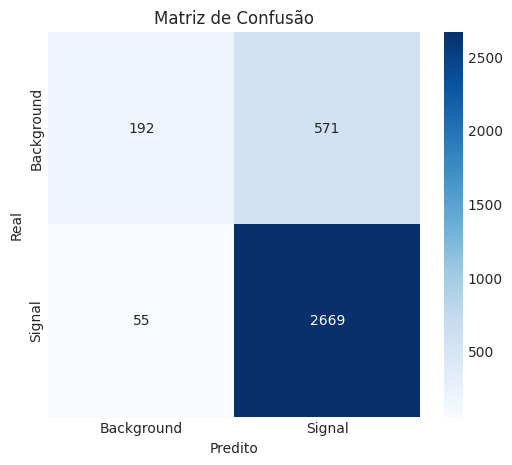

<Figure size 1200x800 with 0 Axes>

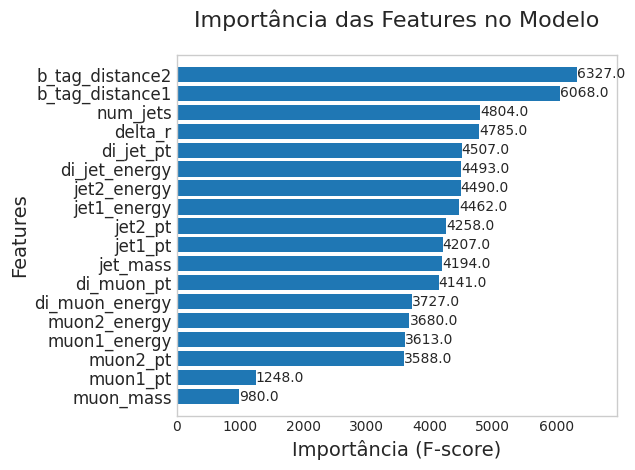

In [67]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Definir os nomes das features
feature_names = [
    'muon_mass', 'muon1_pt', 'muon2_pt', 'muon1_energy', 'muon2_energy',
    'di_muon_energy', 'di_muon_pt', 'jet_mass', 'jet1_pt', 'jet2_pt',
    'jet1_energy', 'jet2_energy', 'di_jet_energy', 'di_jet_pt', 'delta_r',
    'num_jets', 'b_tag_distance1', 'b_tag_distance2'
]

# 1. Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

# 2. Confusion Matrix
print("\n=== Confusion Matrix ===")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Plot da Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=['Background', 'Signal'],
            yticklabels=['Background', 'Signal'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# 3. Importância das features com nomes personalizados
plt.figure(figsize=(12, 8))
ax = xgb.plot_importance(model, 
                        max_num_features=18, 
                        height=0.8,
                        importance_type='weight',
                        xlabel='F-score',
                        title='Importância das Features (XGBoost)',
                        grid=False)

# Ajustar os rótulos para usar os nomes corretos
ax.set_yticklabels(feature_names, fontsize=12)
ax.set_xlabel('Importância (F-score)', fontsize=14)
ax.set_ylabel('Features', fontsize=14)
ax.set_title('Importância das Features no Modelo', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

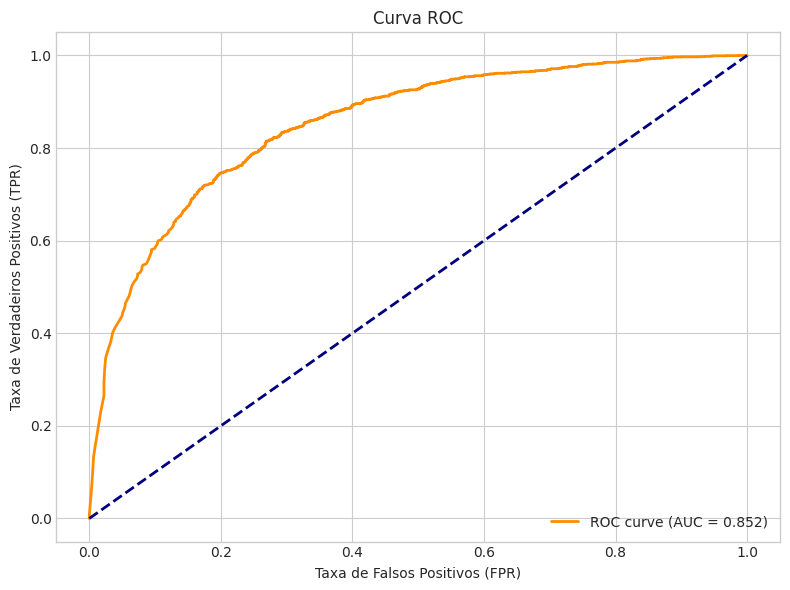

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Calcular as taxas de falso positivo e verdadeiro positivo
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


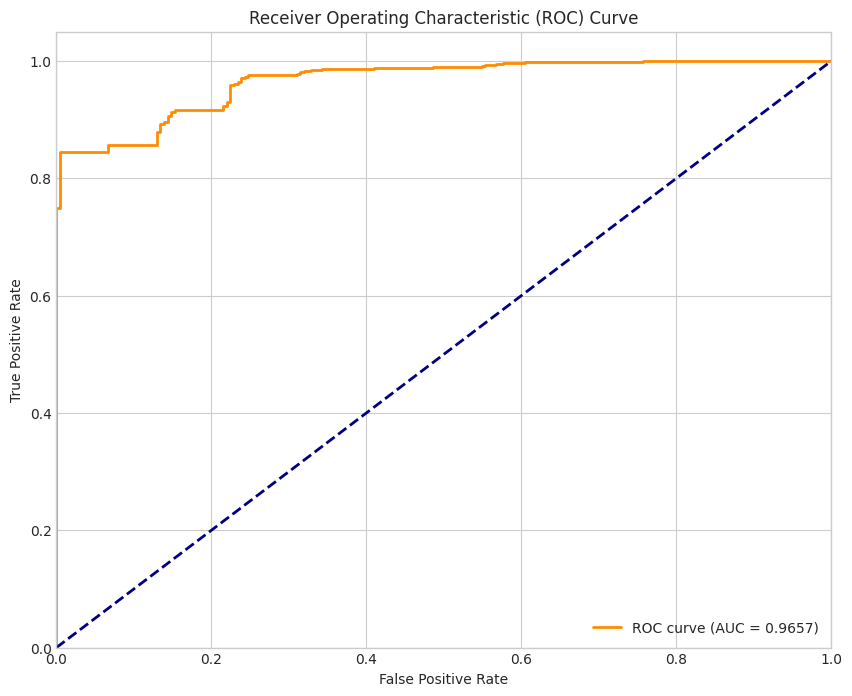

AUC ponderado: 0.9657


In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Calcular as probabilidades da classe positiva
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Curva ROC com pesos
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, sample_weight=weights_test)
roc_auc = roc_auc_score(y_test, y_pred_proba, sample_weight=weights_test)

# Plotar
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC ponderado: {roc_auc:.4f}")


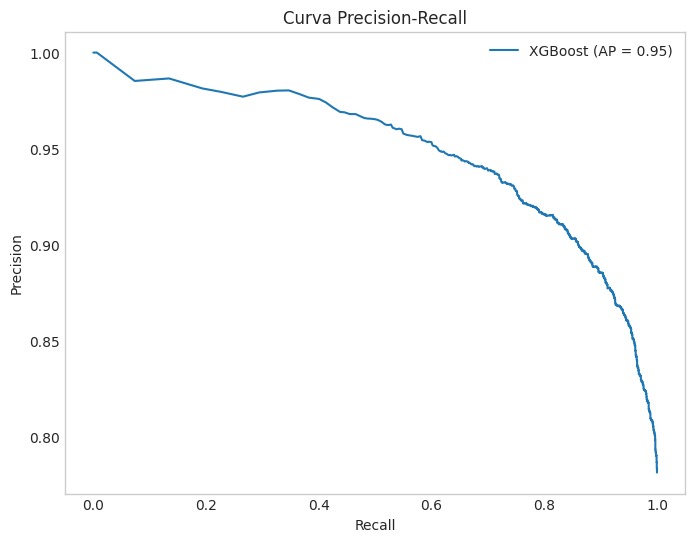


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.78      0.25      0.38       763
           1       0.82      0.98      0.90      2724

    accuracy                           0.82      3487
   macro avg       0.80      0.62      0.64      3487
weighted avg       0.81      0.82      0.78      3487


Average Precision (AP): 0.9478


In [49]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Calcular as métricas para a curva Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

# Plotar a curva Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'XGBoost (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid()
plt.show()

# Você também pode adicionar outras métricas importantes
from sklearn.metrics import classification_report

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))
print(f"\nAverage Precision (AP): {average_precision:.4f}")

In [50]:
cut = 0.5 

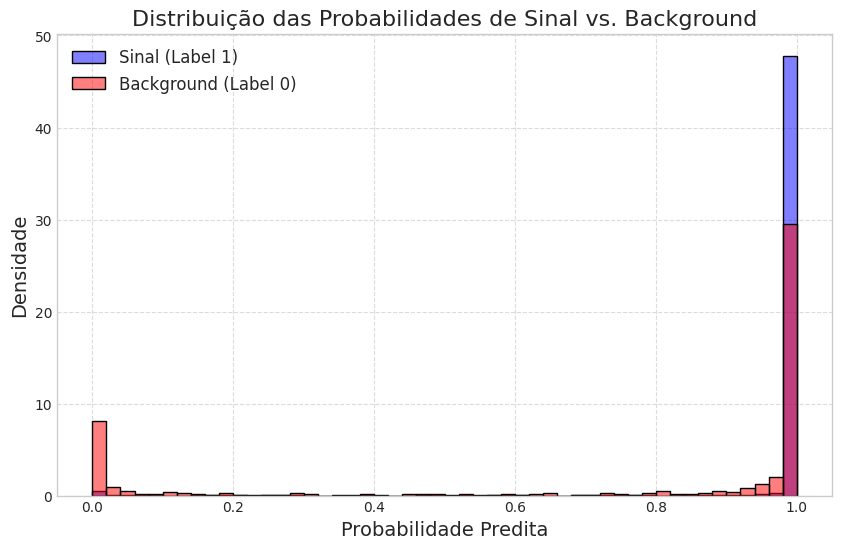

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Criar DataFrame com as probabilidades e labels verdadeiros
prob_df = pd.DataFrame({
    'Probability': y_pred_proba,
    'True Label': y_test
})

# Separar as probabilidades para sinal (label 1) e background (label 0)
signal_probs = prob_df[prob_df['True Label'] == 1]['Probability']
bkg_probs = prob_df[prob_df['True Label'] == 0]['Probability']

# Plotar as distribuições
plt.figure(figsize=(10, 6))
sns.histplot(signal_probs, bins=50, color='blue', alpha=0.5, label='Sinal (Label 1)', stat='density')
sns.histplot(bkg_probs, bins=50, color='red', alpha=0.5, label='Background (Label 0)', stat='density')

plt.xlabel('Probabilidade Predita', fontsize=14)
plt.ylabel('Densidade', fontsize=14)
plt.title('Distribuição das Probabilidades de Sinal vs. Background', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Estilos disponíveis: ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


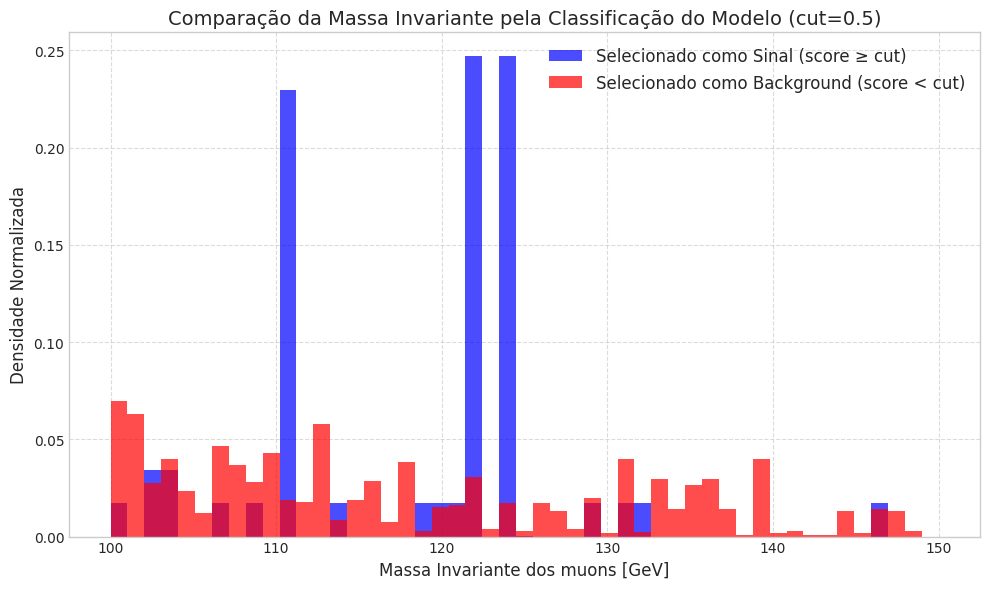

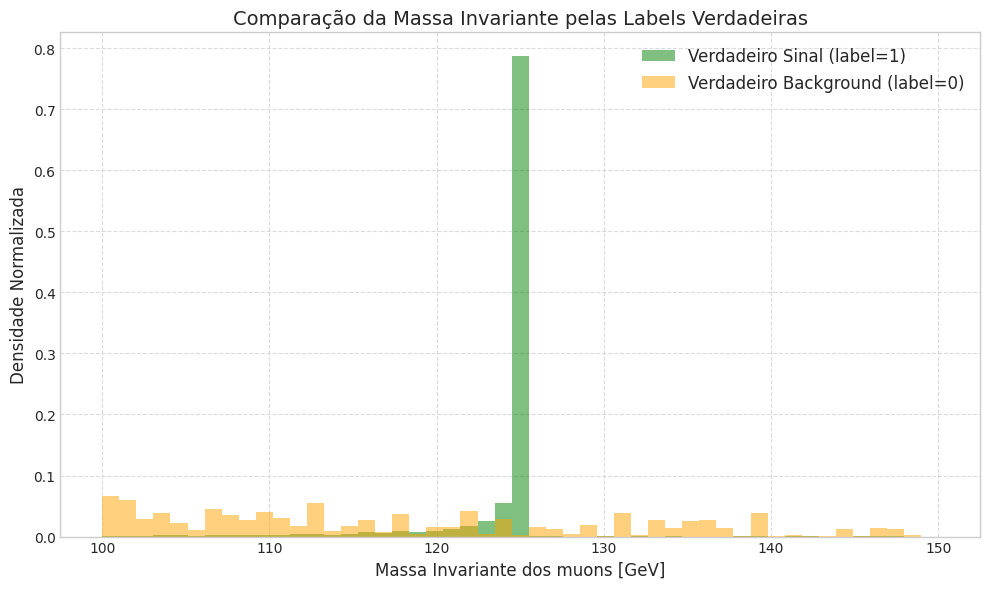

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Carregar o modelo treinado e o scaler (você precisará salvá-los primeiro)
# model = xgb.XGBClassifier()  # Carregue seu modelo treinado aqui
# scaler = StandardScaler()    # Carregue seu scaler treinado aqui

# Carregar seus dados CSV
df = pd.read_csv("/home/lphelipe/Cuts_code/resultados_csv/all_events_cuts_v5.csv")

# Obter previsões do modelo para todo o dataset
X = df.drop(['label', 'weight'], axis=1)
X_scaled = scaler.transform(X)
y_scores = model.predict_proba(X_scaled)[:, 1]  # Probabilidades da classe positiva

# Definir o ponto de corte (cut) - ajuste conforme necessário
cut = 0.5  # Você pode ajustar este valor para otimizar sua seleção

# Máscaras de seleção
selection_mask = (y_scores >= cut)  # Eventos classificados como sinal pelo modelo
selection_maskb = (y_scores < cut)  # Eventos classificados como background pelo modelo

# Verificar estilos disponíveis
print("Estilos disponíveis:", plt.style.available)

# Usar um estilo moderno similar ao seaborn
plt.style.use('seaborn-v0_8-whitegrid')

# Calcular massa invariante para eventos selecionados pelo modelo
signal_mass = df[selection_mask]['muon_mass']
background_mass = df[selection_maskb]['muon_mass']

# Configurações do histograma
plt.figure(figsize=(10, 6))
bins = np.linspace(100, 150, 50)

# Plotar histogramas usando as seleções do modelo
plt.hist(signal_mass, bins=bins, weights=df[selection_mask]['weight'], 
         alpha=0.7, label='Selecionado como Sinal (score ≥ cut)', color='blue', density=True)
plt.hist(background_mass, bins=bins, weights=df[selection_maskb]['weight'], 
         alpha=0.7, label='Selecionado como Background (score < cut)', color='red', density=True)

# Configurações do gráfico
plt.xlabel('Massa Invariante dos muons [GeV]', fontsize=12)
plt.ylabel('Densidade Normalizada', fontsize=12)
plt.title(f'Comparação da Massa Invariante pela Classificação do Modelo (cut={cut})', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

# Opcional: Comparar com as labels verdadeiras
plt.figure(figsize=(10, 6))

# Massa invariante para labels verdadeiras
true_signal_mass = df[df['label'] == 1]['muon_mass']
true_background_mass = df[df['label'] == 0]['muon_mass']

plt.hist(true_signal_mass, bins=bins, weights=df[df['label'] == 1]['weight'],
         alpha=0.5, label='Verdadeiro Sinal (label=1)', color='green', density=True)
plt.hist(true_background_mass, bins=bins, weights=df[df['label'] == 0]['weight'],
         alpha=0.5, label='Verdadeiro Background (label=0)', color='orange', density=True)

plt.xlabel('Massa Invariante dos muons [GeV]', fontsize=12)
plt.ylabel('Densidade Normalizada', fontsize=12)
plt.title('Comparação da Massa Invariante pelas Labels Verdadeiras', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

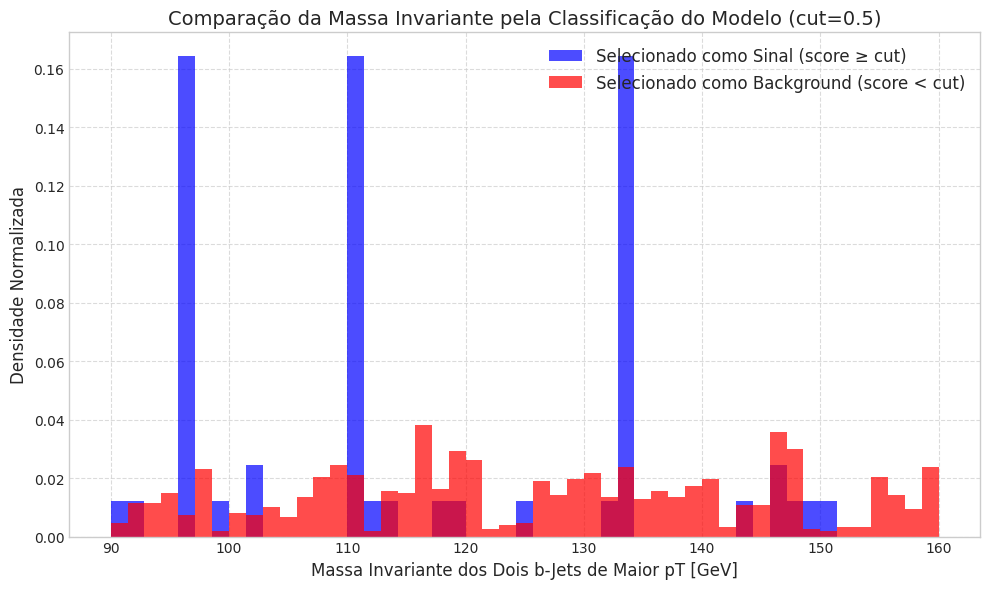

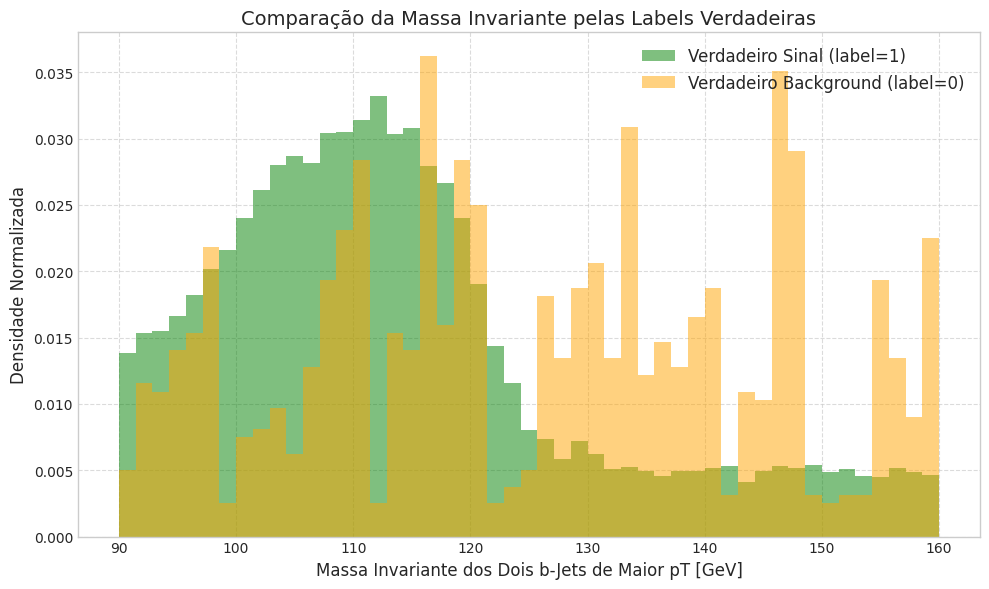

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Carregar o modelo treinado e o scaler (você precisará salvá-los primeiro)
# model = xgb.XGBClassifier()  # Carregue seu modelo treinado aqui
# scaler = StandardScaler()    # Carregue seu scaler treinado aqui

# Carregar seus dados CSV
df = pd.read_csv("/home/lphelipe/Cuts_code/resultados_csv/all_events_cuts_v5.csv")

# Obter previsões do modelo para todo o dataset
X = df.drop(['label', 'weight'], axis=1)
X_scaled = scaler.transform(X)
y_scores = model.predict_proba(X_scaled)[:, 1]  # Probabilidades da classe positiva

# Definir o ponto de corte (cut) - ajuste conforme necessário
cut = 0.5  # Você pode ajustar este valor para otimizar sua seleção

# Máscaras de seleção
selection_mask = (y_scores >= cut)  # Eventos classificados como sinal pelo modelo
selection_maskb = (y_scores < cut)  # Eventos classificados como background pelo modelo

# Usar um estilo moderno similar ao seaborn
plt.style.use('seaborn-v0_8-whitegrid')

# Calcular massa invariante para eventos selecionados pelo modelo
signal_mass = df[selection_mask]['dijet_mass']
background_mass = df[selection_maskb]['dijet_mass']

# Configurações do histograma
plt.figure(figsize=(10, 6))
bins = np.linspace(90, 160, 50)

# Plotar histogramas usando as seleções do modelo
plt.hist(signal_mass, bins=bins, weights=df[selection_mask]['weight'], 
         alpha=0.7, label='Selecionado como Sinal (score ≥ cut)', color='blue', density=True)
plt.hist(background_mass, bins=bins, weights=df[selection_maskb]['weight'], 
         alpha=0.7, label='Selecionado como Background (score < cut)', color='red', density=True)

# Configurações do gráfico
plt.xlabel('Massa Invariante dos Dois b-Jets de Maior pT [GeV]', fontsize=12)
plt.ylabel('Densidade Normalizada', fontsize=12)
plt.title(f'Comparação da Massa Invariante pela Classificação do Modelo (cut={cut})', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

# Opcional: Comparar com as labels verdadeiras
plt.figure(figsize=(10, 6))

# Massa invariante para labels verdadeiras
true_signal_mass = df[df['label'] == 1]['dijet_mass']
true_background_mass = df[df['label'] == 0]['dijet_mass']

plt.hist(true_signal_mass, bins=bins, weights=df[df['label'] == 1]['weight'],
         alpha=0.5, label='Verdadeiro Sinal (label=1)', color='green', density=True)
plt.hist(true_background_mass, bins=bins, weights=df[df['label'] == 0]['weight'],
         alpha=0.5, label='Verdadeiro Background (label=0)', color='orange', density=True)

plt.xlabel('Massa Invariante dos Dois b-Jets de Maior pT [GeV]', fontsize=12)
plt.ylabel('Densidade Normalizada', fontsize=12)
plt.title('Comparação da Massa Invariante pelas Labels Verdadeiras', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

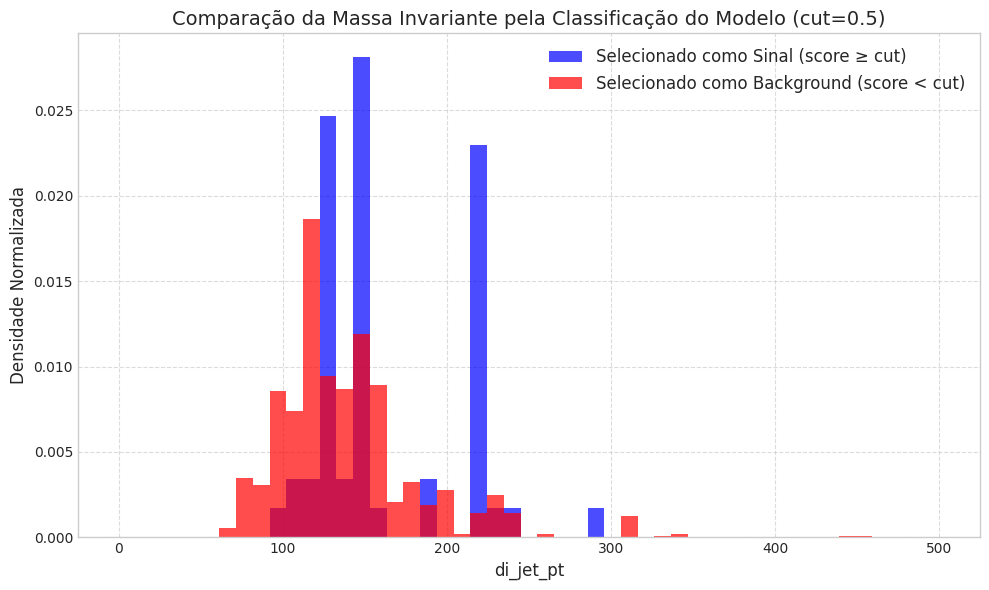

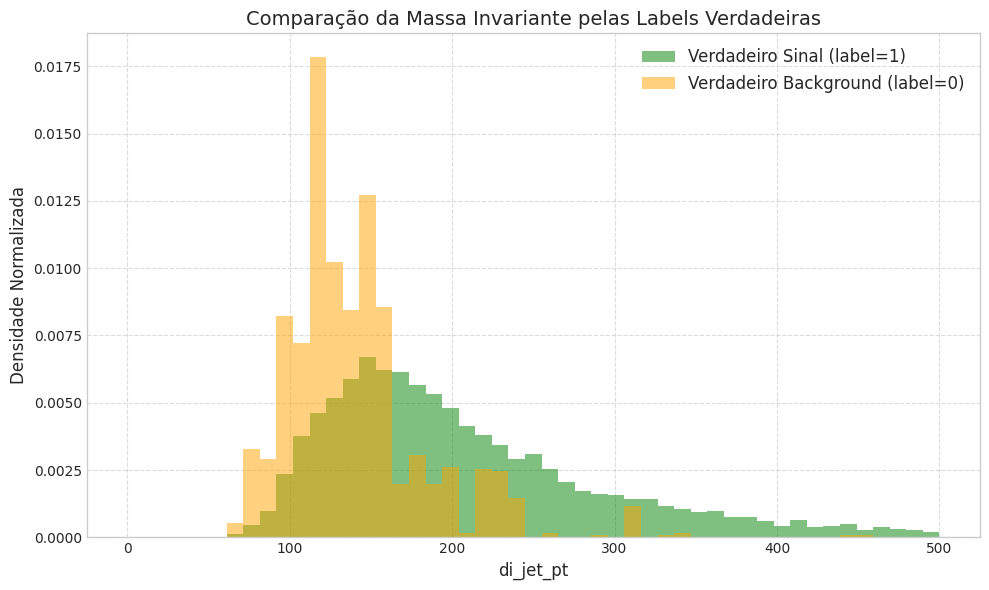

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Carregar o modelo treinado e o scaler (você precisará salvá-los primeiro)
# model = xgb.XGBClassifier()  # Carregue seu modelo treinado aqui
# scaler = StandardScaler()    # Carregue seu scaler treinado aqui

# Carregar seus dados CSV
df = pd.read_csv("/home/lphelipe/Cuts_code/resultados_csv/all_events_cuts_v5.csv")

# Obter previsões do modelo para todo o dataset
X = df.drop(['label', 'weight'], axis=1)
X_scaled = scaler.transform(X)
y_scores = model.predict_proba(X_scaled)[:, 1]  # Probabilidades da classe positiva

# Definir o ponto de corte (cut) - ajuste conforme necessário
cut = 0.5  # Você pode ajustar este valor para otimizar sua seleção

# Máscaras de seleção
selection_mask = (y_scores >= cut)  # Eventos classificados como sinal pelo modelo
selection_maskb = (y_scores < cut)  # Eventos classificados como background pelo modelo

# Usar um estilo moderno similar ao seaborn
plt.style.use('seaborn-v0_8-whitegrid')

# Calcular massa invariante para eventos selecionados pelo modelo
signal_mass = df[selection_mask]['di_jet_pt']
background_mass = df[selection_maskb]['di_jet_pt']

# Configurações do histograma
plt.figure(figsize=(10, 6))
bins = np.linspace(0, 500, 50)

# Plotar histogramas usando as seleções do modelo
plt.hist(signal_mass, bins=bins, weights=df[selection_mask]['weight'], 
         alpha=0.7, label='Selecionado como Sinal (score ≥ cut)', color='blue', density=True)
plt.hist(background_mass, bins=bins, weights=df[selection_maskb]['weight'], 
         alpha=0.7, label='Selecionado como Background (score < cut)', color='red', density=True)

# Configurações do gráfico
plt.xlabel('di_jet_pt', fontsize=12)
plt.ylabel('Densidade Normalizada', fontsize=12)
plt.title(f'Comparação da Massa Invariante pela Classificação do Modelo (cut={cut})', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

# Opcional: Comparar com as labels verdadeiras
plt.figure(figsize=(10, 6))

# Massa invariante para labels verdadeiras
true_signal_mass = df[df['label'] == 1]['di_jet_pt']
true_background_mass = df[df['label'] == 0]['di_jet_pt']

plt.hist(true_signal_mass, bins=bins, weights=df[df['label'] == 1]['weight'],
         alpha=0.5, label='Verdadeiro Sinal (label=1)', color='green', density=True)
plt.hist(true_background_mass, bins=bins, weights=df[df['label'] == 0]['weight'],
         alpha=0.5, label='Verdadeiro Background (label=0)', color='orange', density=True)

plt.xlabel('di_jet_pt', fontsize=12)
plt.ylabel('Densidade Normalizada', fontsize=12)
plt.title('Comparação da Massa Invariante pelas Labels Verdadeiras', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()